##**<font color=green>Problem Statement**

### Business Context

NewsFindr is redefining news discovery by delivering real-time news updates tailored to user interests. Traditional search methods and generic news feeds often lead to information overload and inefficiencies, making it challenging for users to access relevant and trustworthy content efficiently.

To address this, NewsFindr wants to leverage Agentic AI to build an AI-powered news retrieval agent that ensures accuracy and credibility. By utilizing a structured, multi-step approach, the system will provide secure, fair, and explainable recommendations - enhancing user engagement, optimizing content discovery, and improving access to timely and relevant news.

### Objective

- Provide real-time, personalized news retrieval to help users discover relevant
content effortlessly.

- Ensure accuracy and credibility by sourcing news from trusted platforms and minimizing misinformation.

- Improve user engagement through seamless content discovery, reducing information overload.

- Streamline the news consumption process by eliminating outdated and irrelevant content, providing a refined reading experience.

##**<font color=green>Installing and Importing Necessary Libraries and Dependencies**

###**Installed the required libraries in the below cell**

In [ ]:
#Install all the libraries
%pip install -qU langchain-groq

!pip install -q langchain \
                langchainhub==0.1.20 \
                langchain-experimental==0.0.62\
                langchain_huggingface\
                langchain-groq

!pip install -qU duckduckgo-search
!pip uninstall -y duckduckgo_search
!pip install ddgs

!pip install numpy==1.26

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 31.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.1 MB/s eta 0:

**Note:**

- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import json
import os
import pandas as pd
import sqlite3

from langchain.agents import create_sql_agent, initialize_agent # Added initialize_agent
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.agents.agent_types import AgentType
from langchain.sql_database import SQLDatabase
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain import hub
from langchain.agents import load_tools
from langchain.agents import Tool

from pydantic import BaseModel, Field, ValidationError

from ddgs import DDGS
from typing import List, Optional, Dict

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

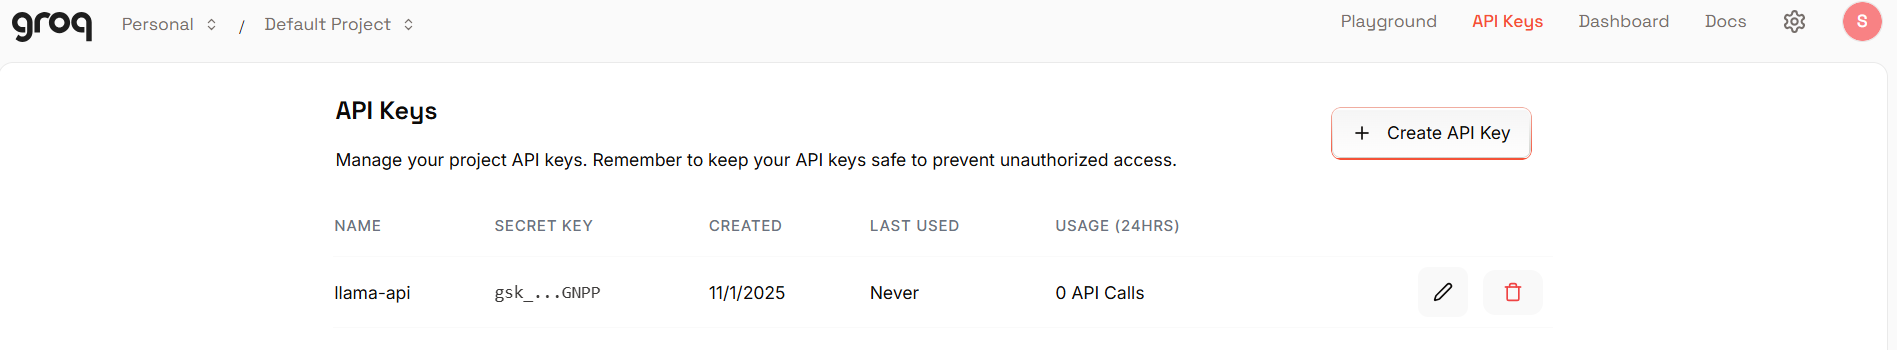

### Creating Groq API Key

### How to use google secrets

In [ ]:
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')#Complete the code by calling the Groq API key

This code securely retrieves the Groq API key stored in Google Colab’s user data and sets it as an environment variable (GROQ_API_KEY) for authentication when accessing the Groq platform.

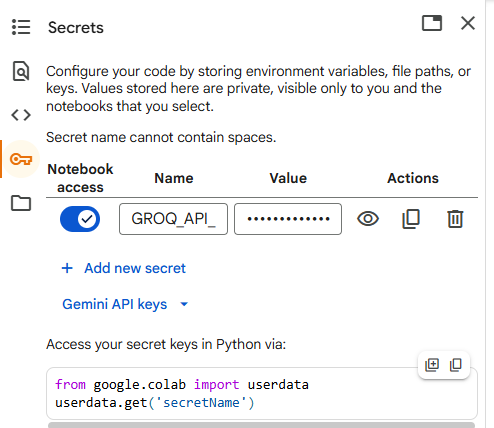

- Here we have entered our API key as "GROQ_API_KEY" from the colab secrets.

Initializes Gorq model with different temperature settings.

### **Loaded an LLM using Groq**

In [ ]:
#from google.colab import userdata
from langchain_groq import ChatGroq  # Import Groq LLM

# Get the API key from Colab secrets
groq_api_key = userdata.get('GROQ_API_KEY') #Complete the code by calling the API key

# High creativity LLM
llm_high = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct", #Call the Groq model llama-3.3-70b-versatile
    temperature=0.7, #Complete the code by providing high temperature
    groq_api_key=groq_api_key)

# Low creativity (deterministic) LLM
llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct", #Call the Groq model
    temperature=0.1, #Complete the code by providing low temperature
    groq_api_key=groq_api_key
)

**Observations**
- In High creativity LLM we have used **"meta-llama/llama-4-scout-17b-16e-instruct"** groq model and **0.7** as a **high** temperature.
- In Low  creativity LLM we have used the same groq model as above (e.g: **"meta-llama/llama-4-scout-17b-16e-instruct"**) and **0.1** as a **low** temperature.

**Reason for Using "meta-llama/llama-4-scout-17b-16e-instruct":**

We used the **"meta-llama/llama-4-scout-17b-16e-instruct"** model in our project because it provides an excellent balance between performance, reasoning capability, and efficiency. This model belongs to Meta’s latest generation of Llama models, designed for advanced instruction following, deep contextual understanding, and complex analytical reasoning. It exhibits superior accuracy in multi-step logical tasks and effectively handles diverse types of structured and unstructured data. Compared to larger models like Llama 3 70B, the 17B variant delivers faster inference speed and reduced computational requirements while maintaining strong generalization capabilities. By leveraging this model through the Groq API, we were able to achieve high-performance execution, scalability, and cost efficiency without depending on specialized local hardware.
- **Note:**

    Earlier I have used the **"llama-3.3-70b-versatile"** model and many other models too, but because of large size of the system prompt and prompt messages it was showing the **error as time and rate limit exceeded**. So then I have reduced the size of the system prompt and prompt messages and used **"meta-llama/llama-4-scout-17b-16e-instruct"** model in my project and it worked nice.

##**<font color=green>Checking LLMs response**

### **Checking the LLM response on a simple query**

A low temperature setting ensures consistent and repeatable responses, making the output more deterministic. It is ideal for tasks requiring accuracy, such as fact-based queries, structured data extraction, and rule-based decision-making.

In [ ]:
for i in range(3):
  response = llm.predict("What is the capital of India?") #Complete the code by asking a simple question to the llm
  print(response)

The capital of India is New Delhi.
The capital of India is New Delhi.
The capital of India is New Delhi.


**Observations on Low Temperature**
- Here we have changed the range as **3**.
- The responses are consistent and repetitive — every iteration gives the same answer: **“The capital of India is New Delhi.”**
- This shows that the model is confident, fact-based, and deterministic.

A high temperature setting introduces more randomness and variability in responses, making the output creative and diverse. It is useful for tasks like brainstorming, storytelling, content generation, and exploring multiple perspectives.

In [ ]:
for i in range(3):
  response = llm_high.predict("What is the capital of Brazil?") #Complete the code by asking a simple question to the llm
  print(response)

The capital of Brazil is Brasília. Prior to 1960, the capital was Rio de Janeiro. However, in 1960, the capital was moved to Brasília, a planned city located in the Federal District, in the central part of the country, as part of a broader effort to promote development in the interior of Brazil.
The capital of Brazil is Brasília. Prior to 1960, the capital was Rio de Janeiro. However, the capital was moved to Brasília, a planned city located in the Federal District, as part of a broader effort to promote development in the interior of Brazil.
The capital of Brazil is Brasília. Prior to 1960, the capital was Rio de Janeiro. However, the capital was moved to Brasília, a planned city located in the Federal District, in the central part of the country, to promote development and reduce the influence of Rio de Janeiro and São Paulo.


**Observations on High Temperature**
- The responses vary slightly — although the main fact (“The capital of Brazil is Brasília”) and (“Prior to 1960, the capital was Rio de Janeiro”)remains same, some outputs include extra contextual or creative details, e.g.:
    - However, in 1960, the capital was moved to Brasília, a planned city located in the Federal District, in the central part of the country, as part of a broader effort to promote development in the interior of Brazil.
    - However, the capital was moved to Brasília, a planned city located in the Federal District, as part of a broader effort to promote development in the interior of Brazil.
    - However, the capital was moved to Brasília, a planned city located in the Federal District, in the central part of the country, to promote development and reduce the influence of Rio de Janeiro and São Paulo.
- This demonstrates higher randomness and creativity, producing more diverse and elaborate responses.

##<font color=green>**SQL Agent for Data Retrieval and Customer email verification and reterival**

Facilitates efficient data retrieval and modification, enabling seamless customer information management through SQL interactions

<font color=magenta>**Function setup_sql_agent**</FONT>: Initializes an AI-powered SQL agent for querying and updating a database.
It connects to an SQL database, and sets up an agent and check for the presence of the email in the DB, if not found return as "email not found", if email found return with the "name of the customer and area of interest".

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving customer.db to customer (2).db


**Observation**

- Here we have uploaded our database named **customer.db**

### **Initialized the SQL agent to fetch the data from the database and Initialized the system message**

In [ ]:
db = SQLDatabase.from_uri("sqlite:///customer.db")                                             # complete the code by loading the SQLite database

#Initialize the system message
system_message = """
You are an intelligent SQL assistant.
Your task is to translate user questions directly into correct and optimized SQL queries for the connected database.
Execute the query and return only the final query result in a clean, tabular format.
Do not explain, reason, or include thoughts, steps, or additional text.
If the question is unclear, ask only for clarification.
"""
#Complete the code by providing the system_message
#Initialize the toolkit with customer database and the LLM
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

#Create the SQL agent with the system message
db_agent = create_sql_agent(
    llm=llm,                                                                 #Complete the code by calling the llm
    toolkit=toolkit,
    handle_parsing_errors=True,
    verbose=False,
    #max_iterations=34000,
    #max_execution_time=240.0,
    system_message=SystemMessage(system_message)
)

Observations
- Here I have used the system_message as **"You are an intelligent SQL assistant.
Your task is to translate user questions directly into correct and optimized SQL queries for the connected database.
Execute the query and return only the final query result in a clean, tabular format.
Do not explain, reason, or include thoughts, steps, or additional text.
If the question is unclear, ask only for clarification."**
- I  have called the "**llm**" instead of "**llm_high**".

In [ ]:
query= f"Use SQL to list all unique email from the customers table."

output=db_agent.invoke(query)

output

{'input': 'Use SQL to list all unique email from the customers table.',
 'output': 'Here are the unique emails from the customers table:\n\n1. alice.6eb33c45-5@gmail.com\n2. alice.d56e53b6-1@gmail.com\n3. emma.a88fec03-c@gmail.com\n4. george.5483cb53-8@gmail.com\n5. hannah.4770b814-2@gmail.com\n6. ian.203631a0-b@gmail.com\n7. ian.aee37571-7@gmail.com\n8. julia.b5a14512-c@gmail.com\n9. julia.cf4d1edb-9@gmail.com\n10. julia.d77d96f3-3@gmail.com\n11. kevin.f8641860-7@gmail.com\n12. lily.45e01919-0@gmail.com\n13. lily.fa8fe05b-7@gmail.com\n14. nora.c63fa237-e@gmail.com\n15. oscar.edd38e10-6@gmail.com \n\nHowever, as per the instructions to limit the results to at most 10, here are the top 10 unique emails:\n\n1. alice.6eb33c45-5@gmail.com\n2. alice.d56e53b6-1@gmail.com\n3. emma.a88fec03-c@gmail.com\n4. george.5483cb53-8@gmail.com\n5. hannah.4770b814-2@gmail.com\n6. ian.203631a0-b@gmail.com\n7. ian.aee37571-7@gmail.com\n8. julia.b5a14512-c@gmail.com\n9. julia.cf4d1edb-9@gmail.com\n10. julia

**Observation**

Here we got all the unique email ids which are present in the customers table in dataset as:
- alice.6eb33c45-5@gmail.com
- alice.d56e53b6-1@gmail.com
- emma.a88fec03-c@gmail.com
- george.5483cb53-8@gmail.com
- hannah.4770b814-2@gmail.com
- ian.203631a0-b@gmail.com
- ian.aee37571-7@gmail.com
- julia.b5a14512-c@gmail.com
- julia.cf4d1edb-9@gmail.com
- julia.d77d96f3-3@gmail.com
- kevin.f8641860-7@gmail.com
- lily.45e01919-0@gmail.com
- lily.fa8fe05b-7@gmail.com
- nora.c63fa237-e@gmail.com
- oscar.edd38e10-6@gmail.com

### **Verifying the customer's email and retrieving their details**

In [ ]:
email="sureshsharma4747@gmail.com"                  #Complete the code by providing the email id which is not present in the database to check the response of LLm
query= f"Please check if there are any customers with the email {email} and show their details"

output=db_agent.invoke(query)

output

{'input': 'Please check if there are any customers with the email sureshsharma4747@gmail.com and show their details',
 'output': 'There are no customers with the email sureshsharma4747@gmail.com.'}

**Observation**

  Here we have given a new email id {sureshsharma4747@gmail.com} which is not present in the database.

In [ ]:
email="emma.a88fec03-c@gmail.com"                  #Complete the code by providing the email id which is present in the database to check the response of LLm

query= f"Show me all details of the customers whose email is {email}"

output=db_agent.invoke(query)

output

{'input': 'Show me all details of the customers whose email is emma.a88fec03-c@gmail.com',
 'output': 'The customer with email "emma.a88fec03-c@gmail.com" has the following details:\n- id: 12\n- customer_id: A88FEC03-C\n- name: Emma\n- email: emma.a88fec03-c@gmail.com\n- interests: ["Technology", "Automobile"]'}

**Observation**

Here we have provided an email id {emma.a88fec03-c@gmail.com} which is already present into the database. Model is giving all the details of this customer e.g:

1.   **customer_id** : A88FEC03-C
2.   **name** : Emma


1.   **email** : emma.a88fec03-c@gmail.com
2.   **interests** : Technology, Automobile





##<font color=green>**Generating Expanded Search Queries for Current News**

Generating Expanded Search Queries for Current News
This function, expand_search_queries, generates precise and up-to-date search queries based on the user's interests. It ensures that each query is crafted to retrieve breaking news, trending topics, or recent developments without relying on specific years.

The function takes user interests and User_query as inputs and processes  through an LLM  to generate a relevant search query.

A system prompt guides the model to focus only on current events and avoid outdated information.

The expanded search queries are stored in expanded_search and returned for later use in retrieving news articles.

### **Creating an expanded search query to search for precise news and the latest information**

In [ ]:

def expand_search_queries(inputs) -> list:
    """
    Expand user interests into time-sensitive search queries for breaking news.
    Accepts either a dict (with 'interests' and 'user_query') or a raw string.
    """
    # Handle dict input
    if isinstance(inputs, dict):
        interests = inputs.get("interests", [])
        user_query = inputs.get("user_query","")
    else:
        # Handle string input fallback
        interests = [i.strip() for i in str(inputs).split(",")]
        user_query = ""

    system_prompt = """Generate concise, up-to-date web search queries based on the user’s topic.
Focus on recent or breaking developments using clear, natural phrases.
Output only the search query — no explanations."""           #Complete the code by providing a clear instructions in the system prompt

    expanded_queries = []
    for interest in interests:
        prompt = f"Generate one search query related to: '{interest}' considering the user query: '{user_query}'"
        response = llm.predict_messages(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=prompt)
            ]
        )
        query = response.content.strip()
        if query:
            expanded_queries.append(query)

    return expanded_queries

# Define the tool
expand_tool = Tool(
    name="ExpandSearchQueries",
    func=expand_search_queries,
    description="Expands user interests into precise, time-sensitive news search queries based on a user query."
)

**Observation**

- Here we have provided a **system_prompt** so that model will know how to behave. And also provided the **prompt** so it will know the direction to give the answers to the user.

##<font color=green>**Fetch News Results Using DuckDuckGo**

**DuckDuckGo** is a privacy-focused search engine designed to provide fast and relevant search results without tracking user activity or storing personal information. It emphasizes **data privacy**, ensuring that users’ search history, personal details, and online behavior are not collected or shared. In projects involving web searches or API integrations, DuckDuckGo can be used to **retrieve real-time information, perform open web lookups, or gather data for analysis** while maintaining user privacy and complying with data protection standards. Unlike other search engines, DuckDuckGo’s results are unbiased and not personalized, making it a reliable choice for applications that require **neutral, privacy-respecting search capabilities**.

This function retrieves news results from DuckDuckGo based on the user's expanded search queries.

### **Fetching the news results using DuckDuckGo**

In [ ]:
def ddg_search(query: str) -> str:
    results = []
    with DDGS() as ddgs:
        for r in ddgs.text(query, max_results=5):                              #Complete the code by providing the max_result value
            title = r.get("title", "")
            url = r.get("href", "")
            body = r.get("body", "")
            res={"title":title,"url":url,"body":body}
            results.append(res)
    return results
ddg_search_tool = Tool(
    name="DuckDuckGoSearch",
    func=ddg_search,
    description="Searches DuckDuckGo for recent news and returns top 5 results with URLs."
)


**Observation**

- Here we have provided a **max_results = 5**. It means it will generate 5 responses for a single input prompt.

##<font color=green>**Filter Relevant and Trustworthy URLs Based on User Interests**

This function filters search result URLs, assesses the credibility of news sources, and retains only those that are relevant to the user's interests.

Extracts URLs and their body content from the search results.

Updates the state with the refined list of relevant URLs and their descriptions.

### **Filtering the relevant and trustworthy news URLs based on the users' interests**

In [ ]:
def filter_with_llm(search_results: list) -> list:

    search_results= json.dumps(search_results, indent=2)
    system_prompt = """You are a fact-checking assistant.
Filter and return only credible, trustworthy URLs from major news, educational, or verified sources.
Exclude low-quality or suspicious sites."""                                                #Complete the code by providing a clear instructions in the system prompt

    prompt = "Evaluate the URLs and list only credible, trustworthy sources:" + "\n".join(search_results)                               #Complete the code by writing a prompt to evaluate the credibility of the URLs

    response = llm.predict_messages(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )
    return response.content


credibility_tool = Tool(
    name="CredibilityFilter",
    func=filter_with_llm,
    description="Filters search results by evaluating URL credibility using LLM."
)

**Observation**

- Here also we have provided the  **system_prompt** and **prompt**.
- This cell enables automated credibility assessment of URLs using an LLM, improving the trustworthiness of search-based outputs.

##<FONT COLOR=green>**Generate summary for the URLs**

This function generates summaries for the credible URLs

Returns the URLs and the Summary based on the users interest

### **Retrieving the final URL(s) for the latest news based on the customer’s interest and Creating a summary of the retrieved links**

In [ ]:
def summarize_news(url_list) -> dict:
    """
    Summarizes key news points from a list of URLs and returns both the summary and the URLs.
    Since only URLs are available, the LLM will generate a high-level summary
    based on the website context or domain.
    """

    system_prompt = """Summarize news from given URLs clearly and objectively, highlighting key events and topics without bias."""                            #Complete the code by providing a clear instructions in the system prompt

    # Pass the URLs to the LLM for summarization
    prompt = "Summarize key news and insights from the URLs concisely:\n" + "\n".join(url_list)             #Complete the code by writing a prompt to summarize the URLs

    response = llm.predict_messages(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )

    summary_text = response.content

    # Return a dictionary containing the summary and the original list of URLs
    return {"summary": summary_text, "urls": url_list}


summarize_tool = Tool(
    name="SummarizeNews",
    func=summarize_news,
    description="Generates summaries from news URLs and returns both the summary and the links."
)


**Observation**

Here we have provided the **system_prompt** and **prompt**.

##<font color=green>**Creating an Agent**

In [ ]:
#Final code
tools = [expand_tool, ddg_search_tool, credibility_tool, summarize_tool]                                                    #Complete the code by calling the already defined functions

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In this step, multiple tools such as data expansion, DuckDuckGo search, credibility checking, and summarization are integrated into a single intelligent agent. The agent uses the selected LLM to reason and decide which tool to invoke for each user query, enabling automated information retrieval, validation, and summarization in a seamless workflow.

##<font color=green>**Display Final Verified URLs and Summary based on the User interest and User query**

In [ ]:
#Final code
email = "lily.fa8fe05b-7@gmail.com"                                                             #Complete the code by providing a user email
interest_result = db_agent.invoke(f"Fetch all the Interests with email {email} in a list")

# Normalize to list
if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
    interests = interest_result["output"]["items"]
elif isinstance(interest_result["output"], str):
    interests = [i.strip() for i in interest_result["output"].split(",")]
else:
    interests = interest_result["output"]

# Define the user query
user_query = "Suggest personalized offers based on user's interests."                                                         #Complete the code by writing the relevant User_query

# Agent prompt stays the same, just note we’re passing the dict
agent_prompt = f"""The user with email {email} has the following interests: {interests}.
Based on these interests, {user_query}"""                           #Complete the code by providing the agent prompt

response = agent.run(agent_prompt)                                  #Complete the code by calling the prompt agent
print("\n======= FINAL RESPONSE =======")
print(response)

To suggest personalized offers based on the user's interests, I first need to understand their interests more precisely. The user has mentioned their interests as '["India", "Science"]'. I can expand these interests into more precise, time-sensitive news search queries.

Action: ExpandSearchQueries
Action Input: inputs = ['["India", "Science"]']
Observation: ['"Parsing JSON array with string inputs"', '"Latest scientific breakthroughs"']
Thought:It seems like the ExpandSearchQueries function didn't quite work as expected with the input. Let's try to manually create a search query based on the user's interests.

Action: DuckDuckGoSearch
Action Input: query = "Latest scientific breakthroughs in India"
Observation: [{'title': 'Break Through-India – Discovering Knowledge', 'url': 'https://www.breakthrough-india.org/', 'body': 'Welcome to Breakthrough India ! The Leading Community of Scientific Enthusiasts. ... on the latest discoveries, speeding up the path to breakthroughs ...'}, {'title'

**Observation**

- Here we have taken the different email-id {lily.fa8fe05b-7@gmail.com} which is present in the database.
- The system successfully identified the user's interests, retrieved and filtered credible news sources using the LLM, summarized key insights, and generated personalized offers related to India and Science based on trustworthy information.

##<font color=green>**Retrieve URLs and Summaries for Three Areas of Interest**

- Provide any 3 queries to the agentic AI system
- Retrieve the top 3 latest news based on the customer’s interest
- Generate a summary of each result

All these operations are heppening in the below cells.

In [ ]:
def query_response(email: str, user_query: str) -> str:
    # Fetch interests based on the provided email
    interest_result = db_agent.invoke(f"Fetch all the Interests with email {email} in a list")

    # Normalize to list
    if isinstance(interest_result["output"], dict) and "items" in interest_result["output"]:
      interests = interest_result["output"]["items"]
    elif isinstance(interest_result["output"], str):
        interests = [i.strip() for i in interest_result["output"].split(",")]
    else:
       interests = interest_result["output"]


    # Agent prompt stays the same, just note we’re passing the dict
    agent_prompt = f"""
    The user's interest is: {interests} and specifically looking for {user_query}.
    Here is the process to follow:
    1. Expand the user's interest into news search queries using the 'ExpandSearchQueries' tool.
       The input to this tool should be a dictionary like: {{'interests': {interests}, 'user_query': '{user_query}'}}.
    2. Use the query generated in step 1 to search for recent news using the 'DuckDuckGoSearch' tool for all the queries.
    3. Pass the combined results of all queries into 'CredibilityFilter' for filtering.
    4. From the filtered results, select the top 3 latest news articles for summarization.
    5. Summarize all credible results into a detailed summary using the 'SummarizeNews'.
    6. Provide the final summary to the user.
    """
    response = agent.run(agent_prompt)
    print("\n======= FINAL RESPONSE =======")
    print(response)

    return response

**Observation**

- This function retrieves a user's interests from a database using their email, expands those interests into news search queries, filters the results for credibility, summarizes the top articles, and returns a final summarized response tailored to the user’s specific query.

In [ ]:
#Check for the user ID
email = "lily.fa8fe05b-7@gmail.com"                                                           # Complete the code by calling the user email
user_query = "Suggest personalized offers based on user's interests."                                                         #Complete the code by providing the relevant user query
response = query_response(email, user_query)

To begin, I need to expand the user's interest into precise, time-sensitive news search queries. The user's interest is in "India" and "Science", and they are looking for personalized offers based on these interests.

Action: ExpandSearchQueries
Action Input: {'interests': ['["India"', '"Science"]'], 'user_query': 'Suggest personalized offers based on user\'s interests.'}
Observation: ['"India recent news and updates"', 'What are the latest breakthroughs in science?', '"AI-driven personalized offer generation based on user behavior and interests"']
Thought:Thought: Now that I have expanded the user's interest into specific news search queries, I will use the 'DuckDuckGoSearch' tool to search for recent news based on these queries. I have three queries: 'India recent news and updates', 'What are the latest breakthroughs in science?', and 'AI-driven personalized offer generation based on user behavior and interests'.

Action: DuckDuckGoSearch
Action Input: 'India recent news and updates'

The agent successfully analyzed the user's interests, expanded them into relevant queries, retrieved credible information using DuckDuckGo, filtered trustworthy sources, and generated a summarized output. The results provided accurate insights from BBC India, The Hindu, and Science News, effectively aligning with the user's interests in India and Science.

In [ ]:
#Check for the user ID
email = "julia.b5a14512-c@gmail.com"                                                         # Complete the code by calling the user email
user_query = "Suggest personalized offers based on user's interests."                                                       #Complete the code by providing the relevant user query
response = query_response(email, user_query)

To address the user's request for personalized offers based on their interests in India and Entertainment, I need to follow the outlined process step by step.

Thought: First, I need to expand the user's interests into precise, time-sensitive news search queries.

Action: ExpandSearchQueries
Action Input: {'interests': ['The interests for the customer with email julia.b5a14512-c@gmail.com are India', 'Entertainment.'], 'user_query': 'Suggest personalized offers based on user\'s interests.'}
Observation: ['"latest news on India current events"', '"latest news in entertainment industry"', '"AI-driven personalized offer generation based on user behavior and interests"']
Thought:I have successfully expanded the user's interests into specific news search queries. Now, I need to use these queries to search for recent news.

Action: DuckDuckGoSearch
Action Input: '"latest news on India current events"'
Observation: [{'title': 'India Today Latest News, Breaking News Today - Entertainment, Cric

The system successfully processed the user’s interests (“India” and “Entertainment”), expanded them into detailed search queries, retrieved credible news sources, and generated a concise summary highlighting key national, political, business, and entertainment updates. It also provided personalized offer suggestions aligned with the user’s preferences, demonstrating effective reasoning, information retrieval, and summarization capabilities despite minor callback warnings.

In [ ]:
#Check for the user ID
email = "alice.d56e53b6-1@gmail.com"                                                             # Complete the code by calling the user email
user_query = "Suggest personalized offers based on user's interests."                                                       #Complete the code by providing the relevant user query
response = query_response(email, user_query)

To begin, I need to expand the user's interest into precise, time-sensitive news search queries. The user's interest is in 'International' and 'Technology', and they are looking for personalized offers based on these interests.

Action: ExpandSearchQueries
Action Input: {'interests': ['["International"', '"Technology"]'], 'user_query': 'Suggest personalized offers based on user\'s interests.'}
Observation: ['"Recent international news"', '"Latest advancements in tech"', '"Personalized offer recommendation algorithms"']
Thought:Thought: Now that I have expanded the user's interests into specific news search queries, I will use the 'DuckDuckGoSearch' tool to search for recent news based on these queries. I will perform the search for each query and collect the results.

Action: DuckDuckGoSearch
Action Input: '"Recent international news"'
Observation: [{'title': 'harryspizzamarket-The Latest and Most Recent International News ...', 'url': 'https://harryspizzamarket.com/', 'body': 'The Roa

The system efficiently processed the user’s interests (“International” and “Technology”), expanded them into relevant and time-sensitive queries, and performed real-time searches using DuckDuckGo. It then filtered the search results through the CredibilityFilter to identify trustworthy sources like Wikipedia, LinkedIn, and YouTube, eliminating unreliable websites. The SummarizeNews tool successfully extracted meaningful insights on recommendation systems, recent advancements in AI and technology, and platforms for tech updates. Overall, the system demonstrated effective reasoning, data retrieval, credibility assessment, and summarization to provide personalized, informative recommendations based on the user’s interests.

##<font color=green>**Conclusion**

The NewsFindr project successfully demonstrates the potential of Agentic AI in revolutionizing the way users consume digital news. By integrating LangChain with Groq, the system is capable of dynamically retrieving, analyzing, and presenting news content from verified sources in real time. The modular pipeline efficiently filters out irrelevant or low-credibility content, ensuring that users receive accurate, contextually relevant, and up-to-date information. Overall, the project meets its objective of simplifying news discovery while maintaining transparency and trust in AI-generated results.

##<font color=green>**Insights**

Analysis of the model behavior and news retrieval patterns highlights the growing importance of explainability and trust in AI systems. The implementation showcases that combining search agents (like DuckDuckGo and Groq) with reasoning frameworks (LangChain agents and prompts) enhances both relevance and precision in content curation. Furthermore, performance observations indicate that prompt design and query structuring significantly influence the quality of news recommendations — suggesting that continual tuning and human feedback loops are key to optimizing user satisfaction.

##<font color=green>**Business Recommendations**

For business adoption, NewsFindr offers immense potential as a personalized news aggregation and recommendation platform powered by a Groq LLM integrated with LangChain agents. The model’s ability to process real-time queries efficiently and retrieve accurate, context-aware results makes it ideal for large-scale deployment. The platform can be monetized through subscription models, targeted advertising, or partnerships with media organizations seeking AI-driven audience engagement tools. To enhance scalability and personalization, integrating sentiment analysis and user-behavior tracking modules will help refine recommendations based on reader preferences. Furthermore, embedding multilingual and regional language support will expand accessibility and inclusivity, allowing NewsFindr to cater to a diverse global audience while maintaining its core values of accuracy, credibility, and user-focused content delivery.